# TF-IDF Clustering

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Configuration

In [2]:
path = os.path.join("..","data","./newdata_clean.xlsx")
n_clusters = 12
batch_size = 10000
max_k = 40
max_features = 256  # only consider the top max_features ordered by term frequency across the corpus.

In [3]:
df = pd.read_excel(path)

df = df.dropna() # drop nan entry
# df[pd.isnull(df).any(axis=1)]

le = preprocessing.LabelEncoder()
le.fit(df['catName'].unique())
num_classes = len(le.classes_)
class_list = list(le.classes_)

print(class_list)

print("number of classes:",num_classes)
df.loc[:,'catName'] = le.transform(df.loc[:,'catName'])
data = df.question

['Does the program support certain features?', 'Download/installation issues with Application Manager.', 'Error message pops up when I perform some action.', 'How do I …?', 'How to activate/register my product?', 'How to edit?', 'How to produce file?', 'How to set preferences/settings?', 'How to use certain effects/features?', 'I cannot install/download', 'I forget my password.', 'I have a suggestion', 'I have a suggestion.', 'I have activation problem.', 'I have activation/registration problem.', 'I have already paid, but …', 'I have component activation problem', 'I have install/uninstall/upgrade/patch problems.', 'I have other feedback', 'I have other install/uninstall problems.', 'I have other issue(s)', 'I have other membership question.', 'I have other product feature question.', 'I have other product info/feature question', 'I have other purchasing question.', 'I have other questions.', 'I have other questions/issues.', 'I have other trouble(s).', 'I have pricing/discount questi

## Preprocess Data

In [20]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

import langid

from nltk.corpus import stopwords

stw = stopwords.words('english') + ['nbsp', 'powerdirector', 'cyberlink', 'powerdvd', 'power', 'director', 'ba']
print(stw)
print(len(stw))

def _filter(ori_x):
    x = re.sub('<[^<]*?/?>', ' ', ori_x)        # remove all html tag
    x = re.sub('https?:\/\/[^ ]*', ' ', x)  # remove all url
    x = re.sub('\S*@\S*\s?', ' ', x)        # remove all email address
    x = re.sub('\S*\.\S*\s?', ' ', x, flags=re.IGNORECASE)        # remove all filename
    x = re.sub('[^a-z A-Z]', ' ', x)        # remove all non-english alphabat
    return x
'''
def _correct_word(text1):
    pattern = re.compile(r"(.)\1{2,}")
    text2 = pattern.sub(r"\1\1", text1) # reduce lengthening
    #if text1 != text2:
    #    print(text1, text2)
    text3 = spell(text2).lower() # spell correction
    #if text2 != text3:
    #    print(text2, text3)
    return text3
'''
def _get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def _lemmatization(tokens):
    tagged_sent = pos_tag(tokens)   
    ret = []
    for tag in tagged_sent:
        wordnet_pos = _get_wordnet_pos(tag[1]) or wordnet.NOUN
        ret.append(wnl.lemmatize(tag[0], pos=wordnet_pos))
    return ret

def _remove_stopword(tokens):
    ret = []
    for word in tokens:
        if word not in stw and len(word) > 2:
            ret.append(word)
    return ret

def preprocess(sentence):
    sentence = _filter(sentence.lower())
    tokens = nltk.word_tokenize(sentence)

    #tokens = [self._correct_word(word) for word in tokens] # spell correction
    tokens = _lemmatization(tokens) # lemmatization
    tokens = _remove_stopword(tokens) # remove stopwords
    s = " ".join(tokens)

    return s

from tqdm import tqdm
clean_data = []
reduced_data = []

for s in tqdm(data):
    ret = langid.classify(s)
    if ret[0] != "en" and ret[1] < -100: # remove language other than english
        #print(ret)
        #print(s)
        continue
    else:
        reduced_data.append(s)
        clean_data.append(preprocess(s))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\James_Chu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\James_Chu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!





  0%|                                                                                       | 0/106478 [00:00<?, ?it/s]




  0%|                                                                             | 11/106478 [00:00<16:53, 105.04it/s]




  0%|                                                                             | 24/106478 [00:00<16:09, 109.84it/s]




  0%|                                                                             | 37/106478 [00:00<15:30, 114.37it/s]




  0%|                                                                             | 50/106478 [00:00<15:11, 116.82it/s]




  0%|                                                  

  2%|█▏                                                                         | 1747/106478 [00:14<15:46, 110.65it/s]




  2%|█▏                                                                         | 1759/106478 [00:14<16:27, 106.06it/s]




  2%|█▏                                                                         | 1770/106478 [00:14<16:23, 106.50it/s]




  2%|█▎                                                                         | 1781/106478 [00:14<17:00, 102.63it/s]




  2%|█▎                                                                         | 1793/106478 [00:14<16:20, 106.78it/s]




  2%|█▎                                                                         | 1806/106478 [00:14<15:29, 112.62it/s]




  2%|█▎                                                                         | 1818/106478 [00:15<15:24, 113.18it/s]




  2%|█▎                                                                         | 1832/106478 [00:15<14:35, 119.55it/s]




  2%|█▎ 

  3%|██▍                                                                        | 3509/106478 [00:29<14:51, 115.55it/s]




  3%|██▍                                                                        | 3522/106478 [00:29<14:27, 118.64it/s]




  3%|██▍                                                                        | 3536/106478 [00:29<13:57, 122.95it/s]




  3%|██▍                                                                        | 3549/106478 [00:29<13:51, 123.83it/s]




  3%|██▌                                                                        | 3563/106478 [00:29<13:26, 127.66it/s]




  3%|██▌                                                                        | 3578/106478 [00:29<12:59, 131.96it/s]




  3%|██▌                                                                        | 3592/106478 [00:30<13:01, 131.73it/s]




  3%|██▌                                                                        | 3608/106478 [00:30<12:24, 138.12it/s]




  3%|██▌

  5%|███▉                                                                       | 5513/106478 [00:43<15:09, 110.98it/s]




  5%|███▉                                                                       | 5526/106478 [00:43<14:30, 115.96it/s]




  5%|███▉                                                                       | 5541/106478 [00:44<13:37, 123.45it/s]




  5%|███▉                                                                       | 5555/106478 [00:44<13:18, 126.36it/s]




  5%|███▉                                                                       | 5569/106478 [00:44<13:40, 122.92it/s]




  5%|███▉                                                                       | 5584/106478 [00:44<13:09, 127.73it/s]




  5%|███▉                                                                       | 5599/106478 [00:44<12:42, 132.37it/s]




  5%|███▉                                                                       | 5616/106478 [00:44<12:01, 139.77it/s]




  5%|███

  7%|█████▎                                                                     | 7508/106478 [00:58<11:30, 143.30it/s]




  7%|█████▎                                                                     | 7523/106478 [00:58<11:30, 143.28it/s]




  7%|█████▎                                                                     | 7538/106478 [00:58<11:32, 142.82it/s]




  7%|█████▎                                                                     | 7553/106478 [00:58<12:06, 136.15it/s]




  7%|█████▎                                                                     | 7567/106478 [00:58<12:11, 135.19it/s]




  7%|█████▎                                                                     | 7581/106478 [00:58<12:54, 127.75it/s]




  7%|█████▎                                                                     | 7595/106478 [00:58<12:39, 130.20it/s]




  7%|█████▎                                                                     | 7610/106478 [00:59<12:16, 134.21it/s]




  7%|███

  9%|██████▋                                                                    | 9518/106478 [01:12<11:41, 138.29it/s]




  9%|██████▋                                                                    | 9533/106478 [01:12<11:34, 139.54it/s]




  9%|██████▋                                                                    | 9548/106478 [01:12<11:40, 138.29it/s]




  9%|██████▋                                                                    | 9563/106478 [01:12<11:47, 137.03it/s]




  9%|██████▋                                                                    | 9577/106478 [01:13<11:49, 136.60it/s]




  9%|██████▊                                                                    | 9591/106478 [01:13<12:05, 133.53it/s]




  9%|██████▊                                                                    | 9605/106478 [01:13<12:34, 128.44it/s]




  9%|██████▊                                                                    | 9620/106478 [01:13<12:12, 132.19it/s]




  9%|███

 11%|████████                                                                  | 11532/106478 [01:27<10:54, 144.99it/s]




 11%|████████                                                                  | 11547/106478 [01:27<10:51, 145.72it/s]




 11%|████████                                                                  | 11562/106478 [01:27<10:56, 144.53it/s]




 11%|████████                                                                  | 11577/106478 [01:27<11:28, 137.80it/s]




 11%|████████                                                                  | 11593/106478 [01:27<11:06, 142.37it/s]




 11%|████████                                                                  | 11608/106478 [01:27<11:25, 138.48it/s]




 11%|████████                                                                  | 11622/106478 [01:27<11:31, 137.16it/s]




 11%|████████                                                                  | 11636/106478 [01:28<11:38, 135.74it/s]




 11%|███

 13%|█████████▎                                                                | 13469/106478 [01:41<10:45, 144.08it/s]




 13%|█████████▎                                                                | 13484/106478 [01:41<10:39, 145.49it/s]




 13%|█████████▍                                                                | 13499/106478 [01:42<11:03, 140.14it/s]




 13%|█████████▍                                                                | 13514/106478 [01:42<11:42, 132.31it/s]




 13%|█████████▍                                                                | 13529/106478 [01:42<11:32, 134.13it/s]




 13%|█████████▍                                                                | 13546/106478 [01:42<10:58, 141.14it/s]




 13%|█████████▍                                                                | 13561/106478 [01:42<10:53, 142.15it/s]




 13%|█████████▍                                                                | 13576/106478 [01:42<11:23, 135.91it/s]




 13%|███

 15%|██████████▋                                                               | 15440/106478 [01:56<11:21, 133.51it/s]




 15%|██████████▋                                                               | 15454/106478 [01:56<11:31, 131.69it/s]




 15%|██████████▋                                                               | 15468/106478 [01:57<11:21, 133.55it/s]




 15%|██████████▊                                                               | 15483/106478 [01:57<11:03, 137.06it/s]




 15%|██████████▊                                                               | 15497/106478 [01:57<11:23, 133.11it/s]




 15%|██████████▊                                                               | 15511/106478 [01:57<15:07, 100.27it/s]




 15%|██████████▊                                                               | 15525/106478 [01:57<13:50, 109.55it/s]




 15%|██████████▊                                                               | 15540/106478 [01:57<12:47, 118.54it/s]




 15%|███

 16%|████████████                                                              | 17406/106478 [02:11<11:18, 131.23it/s]




 16%|████████████                                                              | 17420/106478 [02:11<11:38, 127.45it/s]




 16%|████████████                                                              | 17435/106478 [02:11<11:19, 131.12it/s]




 16%|████████████▏                                                             | 17449/106478 [02:12<11:09, 132.99it/s]




 16%|████████████▏                                                             | 17464/106478 [02:12<10:49, 137.04it/s]




 16%|████████████▏                                                             | 17479/106478 [02:12<10:39, 139.21it/s]




 16%|████████████▏                                                             | 17494/106478 [02:12<10:32, 140.78it/s]




 16%|████████████▏                                                             | 17509/106478 [02:12<11:11, 132.51it/s]




 16%|███

 18%|█████████████▍                                                            | 19394/106478 [02:26<10:15, 141.58it/s]




 18%|█████████████▍                                                            | 19411/106478 [02:26<09:54, 146.45it/s]




 18%|█████████████▌                                                            | 19426/106478 [02:26<10:10, 142.59it/s]




 18%|█████████████▌                                                            | 19441/106478 [02:26<10:41, 135.59it/s]




 18%|█████████████▌                                                            | 19457/106478 [02:26<10:17, 140.99it/s]




 18%|█████████████▌                                                            | 19472/106478 [02:26<10:27, 138.67it/s]




 18%|█████████████▌                                                            | 19489/106478 [02:27<09:53, 146.64it/s]




 18%|█████████████▌                                                            | 19505/106478 [02:27<09:41, 149.45it/s]




 18%|███

 20%|██████████████▉                                                           | 21424/106478 [02:41<09:41, 146.37it/s]




 20%|██████████████▉                                                           | 21440/106478 [02:41<09:35, 147.83it/s]




 20%|██████████████▉                                                           | 21455/106478 [02:41<09:46, 144.86it/s]




 20%|██████████████▉                                                           | 21471/106478 [02:41<09:40, 146.55it/s]




 20%|██████████████▉                                                           | 21486/106478 [02:41<09:57, 142.21it/s]




 20%|██████████████▉                                                           | 21501/106478 [02:41<10:03, 140.91it/s]




 20%|██████████████▉                                                           | 21516/106478 [02:42<09:55, 142.64it/s]




 20%|██████████████▉                                                           | 21531/106478 [02:42<10:50, 130.56it/s]




 20%|███

 22%|████████████████▎                                                         | 23391/106478 [02:56<09:33, 144.76it/s]




 22%|████████████████▎                                                         | 23406/106478 [02:56<11:22, 121.80it/s]




 22%|████████████████▎                                                         | 23419/106478 [02:56<12:55, 107.08it/s]




 22%|████████████████▎                                                         | 23431/106478 [02:56<13:03, 106.05it/s]




 22%|████████████████▎                                                         | 23443/106478 [02:56<13:41, 101.10it/s]




 22%|████████████████▎                                                         | 23454/106478 [02:56<13:29, 102.53it/s]




 22%|████████████████▎                                                         | 23466/106478 [02:56<12:55, 107.01it/s]




 22%|████████████████▎                                                         | 23480/106478 [02:57<12:08, 113.96it/s]




 22%|███

 24%|█████████████████▌                                                        | 25299/106478 [03:11<11:39, 116.06it/s]




 24%|█████████████████▌                                                        | 25312/106478 [03:11<12:08, 111.47it/s]




 24%|█████████████████▌                                                        | 25324/106478 [03:11<11:55, 113.35it/s]




 24%|█████████████████▌                                                        | 25337/106478 [03:11<11:36, 116.43it/s]




 24%|█████████████████▌                                                        | 25350/106478 [03:11<11:54, 113.60it/s]




 24%|█████████████████▋                                                        | 25362/106478 [03:11<11:59, 112.76it/s]




 24%|█████████████████▋                                                        | 25375/106478 [03:11<11:39, 115.95it/s]




 24%|█████████████████▋                                                        | 25387/106478 [03:11<11:45, 114.87it/s]




 24%|███

 26%|███████████████████                                                       | 27369/106478 [03:26<10:52, 121.27it/s]




 26%|███████████████████                                                       | 27382/106478 [03:26<10:58, 120.09it/s]




 26%|███████████████████                                                       | 27395/106478 [03:26<11:10, 117.99it/s]




 26%|███████████████████                                                       | 27413/106478 [03:26<10:05, 130.53it/s]




 26%|███████████████████                                                       | 27436/106478 [03:26<08:51, 148.61it/s]




 26%|███████████████████                                                       | 27453/106478 [03:26<08:32, 154.13it/s]




 26%|███████████████████                                                       | 27470/106478 [03:26<08:40, 151.90it/s]




 26%|███████████████████                                                       | 27486/106478 [03:26<08:34, 153.49it/s]




 26%|███

 28%|████████████████████▌                                                     | 29524/106478 [03:41<09:07, 140.53it/s]




 28%|████████████████████▌                                                     | 29539/106478 [03:41<09:32, 134.49it/s]




 28%|████████████████████▌                                                     | 29553/106478 [03:41<09:30, 134.85it/s]




 28%|████████████████████▌                                                     | 29571/106478 [03:41<08:50, 144.86it/s]




 28%|████████████████████▌                                                     | 29586/106478 [03:41<08:49, 145.22it/s]




 28%|████████████████████▌                                                     | 29601/106478 [03:41<08:50, 145.03it/s]




 28%|████████████████████▌                                                     | 29619/106478 [03:41<08:22, 152.93it/s]




 28%|████████████████████▌                                                     | 29642/106478 [03:41<07:33, 169.39it/s]




 28%|███

 30%|██████████████████████                                                    | 31727/106478 [03:55<08:15, 151.00it/s]




 30%|██████████████████████                                                    | 31743/106478 [03:55<08:12, 151.75it/s]




 30%|██████████████████████                                                    | 31760/106478 [03:55<08:00, 155.64it/s]




 30%|██████████████████████                                                    | 31776/106478 [03:55<08:07, 153.19it/s]




 30%|██████████████████████                                                    | 31792/106478 [03:55<08:03, 154.39it/s]




 30%|██████████████████████                                                    | 31808/106478 [03:56<08:03, 154.37it/s]




 30%|██████████████████████                                                    | 31824/106478 [03:56<08:15, 150.61it/s]




 30%|██████████████████████▏                                                   | 31840/106478 [03:56<08:28, 146.67it/s]




 30%|███

 32%|███████████████████████▍                                                  | 33777/106478 [04:10<09:03, 133.86it/s]




 32%|███████████████████████▍                                                  | 33795/106478 [04:10<08:25, 143.75it/s]




 32%|███████████████████████▍                                                  | 33811/106478 [04:10<08:13, 147.31it/s]




 32%|███████████████████████▌                                                  | 33827/106478 [04:10<08:07, 149.18it/s]




 32%|███████████████████████▌                                                  | 33843/106478 [04:11<08:12, 147.35it/s]




 32%|███████████████████████▌                                                  | 33860/106478 [04:11<07:59, 151.56it/s]




 32%|███████████████████████▌                                                  | 33876/106478 [04:11<07:52, 153.66it/s]




 32%|███████████████████████▌                                                  | 33894/106478 [04:11<07:37, 158.72it/s]




 32%|███

 34%|████████████████████████▉                                                 | 35807/106478 [04:25<10:08, 116.21it/s]




 34%|████████████████████████▉                                                 | 35824/106478 [04:25<09:11, 128.19it/s]




 34%|████████████████████████▉                                                 | 35841/106478 [04:25<08:43, 134.92it/s]




 34%|████████████████████████▉                                                 | 35855/106478 [04:26<09:00, 130.61it/s]




 34%|████████████████████████▉                                                 | 35869/106478 [04:26<09:10, 128.26it/s]




 34%|████████████████████████▉                                                 | 35883/106478 [04:26<09:50, 119.64it/s]




 34%|████████████████████████▉                                                 | 35896/106478 [04:26<10:22, 113.33it/s]




 34%|████████████████████████▉                                                 | 35908/106478 [04:26<10:54, 107.89it/s]




 34%|███

 35%|██████████████████████████▏                                               | 37727/106478 [04:40<08:44, 131.13it/s]




 35%|██████████████████████████▏                                               | 37743/106478 [04:40<08:28, 135.22it/s]




 35%|██████████████████████████▏                                               | 37757/106478 [04:40<08:40, 131.96it/s]




 35%|██████████████████████████▎                                               | 37772/106478 [04:40<08:33, 133.71it/s]




 35%|██████████████████████████▎                                               | 37787/106478 [04:41<08:21, 137.06it/s]




 36%|██████████████████████████▎                                               | 37801/106478 [04:41<08:44, 131.05it/s]




 36%|██████████████████████████▎                                               | 37815/106478 [04:41<08:34, 133.33it/s]




 36%|██████████████████████████▎                                               | 37831/106478 [04:41<08:17, 137.90it/s]




 36%|███

 37%|███████████████████████████▌                                              | 39589/106478 [04:55<08:36, 129.49it/s]




 37%|███████████████████████████▌                                              | 39603/106478 [04:55<08:33, 130.35it/s]




 37%|███████████████████████████▌                                              | 39617/106478 [04:55<08:31, 130.68it/s]




 37%|███████████████████████████▌                                              | 39631/106478 [04:55<08:38, 128.80it/s]




 37%|███████████████████████████▌                                              | 39644/106478 [04:55<08:51, 125.71it/s]




 37%|███████████████████████████▌                                              | 39657/106478 [04:55<08:50, 125.86it/s]




 37%|███████████████████████████▌                                              | 39671/106478 [04:55<08:36, 129.23it/s]




 37%|███████████████████████████▌                                              | 39684/106478 [04:55<08:50, 125.84it/s]




 37%|███

 39%|████████████████████████████▊                                             | 41447/106478 [05:09<07:50, 138.08it/s]




 39%|████████████████████████████▊                                             | 41461/106478 [05:09<07:50, 138.33it/s]




 39%|████████████████████████████▊                                             | 41475/106478 [05:09<08:27, 128.07it/s]




 39%|████████████████████████████▊                                             | 41489/106478 [05:09<08:16, 130.95it/s]




 39%|████████████████████████████▊                                             | 41503/106478 [05:10<08:45, 123.61it/s]




 39%|████████████████████████████▊                                             | 41516/106478 [05:10<08:44, 123.76it/s]




 39%|████████████████████████████▊                                             | 41531/106478 [05:10<08:22, 129.21it/s]




 39%|████████████████████████████▊                                             | 41545/106478 [05:10<08:19, 129.95it/s]




 39%|███

 41%|██████████████████████████████                                            | 43318/106478 [05:24<07:35, 138.73it/s]




 41%|██████████████████████████████                                            | 43332/106478 [05:24<07:34, 139.01it/s]




 41%|██████████████████████████████                                            | 43346/106478 [05:24<07:40, 136.97it/s]




 41%|██████████████████████████████▏                                           | 43360/106478 [05:24<07:56, 132.38it/s]




 41%|██████████████████████████████▏                                           | 43374/106478 [05:24<07:53, 133.15it/s]




 41%|██████████████████████████████▏                                           | 43388/106478 [05:24<07:51, 133.69it/s]




 41%|██████████████████████████████▏                                           | 43403/106478 [05:24<07:37, 137.73it/s]




 41%|██████████████████████████████▏                                           | 43417/106478 [05:24<07:52, 133.57it/s]




 41%|███

 42%|███████████████████████████████▍                                          | 45202/106478 [05:38<08:01, 127.27it/s]




 42%|███████████████████████████████▍                                          | 45217/106478 [05:38<07:47, 130.99it/s]




 42%|███████████████████████████████▍                                          | 45231/106478 [05:39<07:55, 128.80it/s]




 42%|███████████████████████████████▍                                          | 45244/106478 [05:39<08:10, 124.86it/s]




 43%|███████████████████████████████▍                                          | 45257/106478 [05:39<08:06, 125.92it/s]




 43%|███████████████████████████████▍                                          | 45271/106478 [05:39<07:58, 127.97it/s]




 43%|███████████████████████████████▍                                          | 45286/106478 [05:39<07:44, 131.85it/s]




 43%|███████████████████████████████▍                                          | 45301/106478 [05:39<07:30, 135.80it/s]




 43%|███

 44%|████████████████████████████████▋                                         | 47044/106478 [05:53<06:59, 141.64it/s]




 44%|████████████████████████████████▋                                         | 47059/106478 [05:53<07:36, 130.17it/s]




 44%|████████████████████████████████▋                                         | 47073/106478 [05:53<07:38, 129.57it/s]




 44%|████████████████████████████████▋                                         | 47087/106478 [05:53<07:32, 131.30it/s]




 44%|████████████████████████████████▋                                         | 47101/106478 [05:53<07:26, 132.96it/s]




 44%|████████████████████████████████▋                                         | 47115/106478 [05:53<07:22, 134.28it/s]




 44%|████████████████████████████████▊                                         | 47129/106478 [05:54<07:36, 129.90it/s]




 44%|████████████████████████████████▊                                         | 47143/106478 [05:54<07:29, 131.95it/s]




 44%|███

 46%|█████████████████████████████████▉                                        | 48784/106478 [06:08<08:12, 117.26it/s]




 46%|█████████████████████████████████▉                                        | 48798/106478 [06:08<07:50, 122.70it/s]




 46%|█████████████████████████████████▉                                        | 48811/106478 [06:08<07:53, 121.75it/s]




 46%|█████████████████████████████████▉                                        | 48824/106478 [06:08<07:50, 122.46it/s]




 46%|█████████████████████████████████▉                                        | 48838/106478 [06:08<07:33, 127.00it/s]




 46%|█████████████████████████████████▉                                        | 48852/106478 [06:08<07:25, 129.44it/s]




 46%|█████████████████████████████████▉                                        | 48866/106478 [06:08<07:47, 123.11it/s]




 46%|█████████████████████████████████▉                                        | 48880/106478 [06:09<07:35, 126.47it/s]




 46%|███

 47%|███████████████████████████████████                                       | 50488/106478 [06:22<06:38, 140.53it/s]




 47%|███████████████████████████████████                                       | 50503/106478 [06:22<06:34, 141.77it/s]




 47%|███████████████████████████████████                                       | 50518/106478 [06:23<06:30, 143.21it/s]




 47%|███████████████████████████████████                                       | 50533/106478 [06:23<06:55, 134.49it/s]




 47%|███████████████████████████████████▏                                      | 50547/106478 [06:23<07:03, 131.98it/s]




 47%|███████████████████████████████████▏                                      | 50561/106478 [06:23<07:05, 131.38it/s]




 47%|███████████████████████████████████▏                                      | 50575/106478 [06:23<07:17, 127.76it/s]




 48%|███████████████████████████████████▏                                      | 50588/106478 [06:23<07:16, 128.13it/s]




 48%|███

 49%|████████████████████████████████████▍                                     | 52422/106478 [06:37<06:53, 130.81it/s]




 49%|████████████████████████████████████▍                                     | 52436/106478 [06:37<07:17, 123.49it/s]




 49%|████████████████████████████████████▍                                     | 52450/106478 [06:37<07:08, 126.04it/s]




 49%|████████████████████████████████████▍                                     | 52464/106478 [06:37<06:56, 129.57it/s]




 49%|████████████████████████████████████▍                                     | 52478/106478 [06:37<06:51, 131.13it/s]




 49%|████████████████████████████████████▍                                     | 52492/106478 [06:37<07:12, 124.68it/s]




 49%|████████████████████████████████████▍                                     | 52505/106478 [06:37<07:12, 124.73it/s]




 49%|████████████████████████████████████▍                                     | 52518/106478 [06:37<07:13, 124.54it/s]




 49%|███

 51%|█████████████████████████████████████▊                                    | 54401/106478 [06:51<06:44, 128.60it/s]




 51%|█████████████████████████████████████▊                                    | 54418/106478 [06:51<06:18, 137.47it/s]




 51%|█████████████████████████████████████▊                                    | 54435/106478 [06:52<06:01, 144.08it/s]




 51%|█████████████████████████████████████▊                                    | 54451/106478 [06:52<06:21, 136.50it/s]




 51%|█████████████████████████████████████▊                                    | 54466/106478 [06:52<06:25, 134.91it/s]




 51%|█████████████████████████████████████▊                                    | 54481/106478 [06:52<06:19, 136.93it/s]




 51%|█████████████████████████████████████▊                                    | 54496/106478 [06:52<06:10, 140.12it/s]




 51%|█████████████████████████████████████▉                                    | 54511/106478 [06:52<06:06, 141.89it/s]




 51%|███

 53%|███████████████████████████████████████▏                                  | 56363/106478 [07:06<06:16, 133.00it/s]




 53%|███████████████████████████████████████▏                                  | 56377/106478 [07:06<06:18, 132.20it/s]




 53%|███████████████████████████████████████▏                                  | 56392/106478 [07:06<06:09, 135.49it/s]




 53%|███████████████████████████████████████▏                                  | 56408/106478 [07:06<05:58, 139.71it/s]




 53%|███████████████████████████████████████▏                                  | 56423/106478 [07:06<07:58, 104.61it/s]




 53%|███████████████████████████████████████▏                                  | 56436/106478 [07:06<07:34, 110.07it/s]




 53%|███████████████████████████████████████▏                                  | 56451/106478 [07:07<07:00, 118.85it/s]




 53%|███████████████████████████████████████▏                                  | 56465/106478 [07:07<06:47, 122.61it/s]




 53%|███

 55%|████████████████████████████████████████▌                                 | 58416/106478 [07:20<05:41, 140.71it/s]




 55%|████████████████████████████████████████▌                                 | 58431/106478 [07:21<05:49, 137.58it/s]




 55%|████████████████████████████████████████▌                                 | 58445/106478 [07:21<05:47, 138.21it/s]




 55%|████████████████████████████████████████▋                                 | 58459/106478 [07:21<05:50, 136.81it/s]




 55%|████████████████████████████████████████▋                                 | 58476/106478 [07:21<05:32, 144.32it/s]




 55%|████████████████████████████████████████▋                                 | 58491/106478 [07:21<06:02, 132.22it/s]




 55%|████████████████████████████████████████▋                                 | 58505/106478 [07:21<06:05, 131.16it/s]




 55%|████████████████████████████████████████▋                                 | 58519/106478 [07:21<06:10, 129.37it/s]




 55%|███

 57%|█████████████████████████████████████████▊                                | 60189/106478 [07:35<07:19, 105.33it/s]




 57%|█████████████████████████████████████████▊                                | 60200/106478 [07:35<07:17, 105.86it/s]




 57%|█████████████████████████████████████████▊                                | 60213/106478 [07:35<06:56, 111.17it/s]




 57%|█████████████████████████████████████████▊                                | 60225/106478 [07:35<06:55, 111.24it/s]




 57%|█████████████████████████████████████████▊                                | 60238/106478 [07:35<06:38, 116.05it/s]




 57%|█████████████████████████████████████████▊                                | 60250/106478 [07:36<06:45, 113.96it/s]




 57%|█████████████████████████████████████████▉                                | 60263/106478 [07:36<06:32, 117.79it/s]




 57%|█████████████████████████████████████████▉                                | 60280/106478 [07:36<06:00, 128.07it/s]




 57%|███

 58%|███████████████████████████████████████████                               | 61958/106478 [07:49<05:56, 124.83it/s]




 58%|███████████████████████████████████████████                               | 61972/106478 [07:49<05:52, 126.32it/s]




 58%|███████████████████████████████████████████                               | 61985/106478 [07:50<05:50, 126.91it/s]




 58%|███████████████████████████████████████████                               | 61998/106478 [07:50<05:58, 123.92it/s]




 58%|███████████████████████████████████████████                               | 62011/106478 [07:50<06:03, 122.22it/s]




 58%|███████████████████████████████████████████                               | 62024/106478 [07:50<06:01, 122.96it/s]




 58%|███████████████████████████████████████████                               | 62037/106478 [07:50<05:55, 124.92it/s]




 58%|███████████████████████████████████████████                               | 62051/106478 [07:50<05:49, 127.03it/s]




 58%|███

 60%|████████████████████████████████████████████▎                             | 63732/106478 [08:04<06:28, 110.00it/s]




 60%|████████████████████████████████████████████▎                             | 63744/106478 [08:04<06:28, 109.97it/s]




 60%|████████████████████████████████████████████▎                             | 63759/106478 [08:04<06:00, 118.47it/s]




 60%|████████████████████████████████████████████▎                             | 63772/106478 [08:04<05:51, 121.44it/s]




 60%|████████████████████████████████████████████▎                             | 63785/106478 [08:04<05:50, 121.90it/s]




 60%|████████████████████████████████████████████▎                             | 63798/106478 [08:04<05:44, 123.95it/s]




 60%|████████████████████████████████████████████▎                             | 63812/106478 [08:05<05:38, 125.93it/s]




 60%|████████████████████████████████████████████▎                             | 63825/106478 [08:05<05:36, 126.68it/s]




 60%|███

 62%|█████████████████████████████████████████████▌                            | 65556/106478 [08:18<05:07, 133.27it/s]




 62%|█████████████████████████████████████████████▌                            | 65570/106478 [08:18<05:12, 130.80it/s]




 62%|█████████████████████████████████████████████▌                            | 65586/106478 [08:19<04:57, 137.31it/s]




 62%|█████████████████████████████████████████████▌                            | 65602/106478 [08:19<04:47, 142.15it/s]




 62%|█████████████████████████████████████████████▌                            | 65617/106478 [08:19<04:59, 136.47it/s]




 62%|█████████████████████████████████████████████▌                            | 65632/106478 [08:19<04:51, 140.11it/s]




 62%|█████████████████████████████████████████████▌                            | 65648/106478 [08:19<04:43, 144.08it/s]




 62%|█████████████████████████████████████████████▋                            | 65663/106478 [08:19<05:09, 131.74it/s]




 62%|███

 63%|██████████████████████████████████████████████▉                           | 67464/106478 [08:33<04:49, 134.94it/s]




 63%|██████████████████████████████████████████████▉                           | 67478/106478 [08:33<04:49, 134.55it/s]




 63%|██████████████████████████████████████████████▉                           | 67492/106478 [08:33<04:53, 132.77it/s]




 63%|██████████████████████████████████████████████▉                           | 67506/106478 [08:33<04:51, 133.80it/s]




 63%|██████████████████████████████████████████████▉                           | 67520/106478 [08:33<04:51, 133.58it/s]




 63%|██████████████████████████████████████████████▉                           | 67534/106478 [08:33<04:54, 132.14it/s]




 63%|██████████████████████████████████████████████▉                           | 67549/106478 [08:33<04:50, 134.20it/s]




 63%|██████████████████████████████████████████████▉                           | 67565/106478 [08:34<04:40, 138.57it/s]




 63%|███

 65%|████████████████████████████████████████████████▏                         | 69309/106478 [08:47<04:25, 140.20it/s]




 65%|████████████████████████████████████████████████▏                         | 69324/106478 [08:47<04:29, 137.98it/s]




 65%|████████████████████████████████████████████████▏                         | 69338/106478 [08:47<05:01, 123.01it/s]




 65%|████████████████████████████████████████████████▏                         | 69351/106478 [08:48<05:13, 118.31it/s]




 65%|████████████████████████████████████████████████▏                         | 69364/106478 [08:48<05:08, 120.32it/s]




 65%|████████████████████████████████████████████████▏                         | 69378/106478 [08:48<04:59, 123.71it/s]




 65%|████████████████████████████████████████████████▏                         | 69391/106478 [08:48<05:11, 119.09it/s]




 65%|████████████████████████████████████████████████▏                         | 69404/106478 [08:48<05:14, 117.94it/s]




 65%|███

 67%|█████████████████████████████████████████████████▍                        | 71061/106478 [09:02<05:18, 111.14it/s]




 67%|█████████████████████████████████████████████████▍                        | 71074/106478 [09:02<05:08, 114.59it/s]




 67%|█████████████████████████████████████████████████▍                        | 71086/106478 [09:02<05:16, 111.99it/s]




 67%|█████████████████████████████████████████████████▍                        | 71099/106478 [09:02<05:08, 114.76it/s]




 67%|█████████████████████████████████████████████████▍                        | 71111/106478 [09:02<05:06, 115.37it/s]




 67%|█████████████████████████████████████████████████▍                        | 71125/106478 [09:03<04:51, 121.13it/s]




 67%|█████████████████████████████████████████████████▍                        | 71139/106478 [09:03<04:42, 125.12it/s]




 67%|█████████████████████████████████████████████████▍                        | 71152/106478 [09:03<04:58, 118.36it/s]




 67%|███

 68%|██████████████████████████████████████████████████▋                       | 72880/106478 [09:17<04:02, 138.71it/s]




 68%|██████████████████████████████████████████████████▋                       | 72895/106478 [09:17<03:57, 141.38it/s]




 68%|██████████████████████████████████████████████████▋                       | 72910/106478 [09:17<04:11, 133.55it/s]




 68%|██████████████████████████████████████████████████▋                       | 72924/106478 [09:17<04:15, 131.51it/s]




 69%|██████████████████████████████████████████████████▋                       | 72939/106478 [09:17<04:08, 134.83it/s]




 69%|██████████████████████████████████████████████████▋                       | 72953/106478 [09:17<04:30, 124.14it/s]




 69%|██████████████████████████████████████████████████▋                       | 72970/106478 [09:17<04:10, 133.89it/s]




 69%|██████████████████████████████████████████████████▋                       | 72987/106478 [09:17<03:56, 141.66it/s]




 69%|███

 70%|███████████████████████████████████████████████████▉                      | 74819/106478 [09:31<04:10, 126.19it/s]




 70%|████████████████████████████████████████████████████                      | 74832/106478 [09:31<04:13, 124.86it/s]




 70%|████████████████████████████████████████████████████                      | 74845/106478 [09:31<04:11, 125.63it/s]




 70%|████████████████████████████████████████████████████                      | 74858/106478 [09:31<04:09, 126.80it/s]




 70%|████████████████████████████████████████████████████                      | 74871/106478 [09:32<04:08, 126.96it/s]




 70%|████████████████████████████████████████████████████                      | 74884/106478 [09:32<04:10, 126.09it/s]




 70%|████████████████████████████████████████████████████                      | 74897/106478 [09:32<04:16, 123.13it/s]




 70%|████████████████████████████████████████████████████                      | 74910/106478 [09:32<04:31, 116.30it/s]




 70%|███

 72%|█████████████████████████████████████████████████████▏                    | 76539/106478 [09:46<04:00, 124.25it/s]




 72%|█████████████████████████████████████████████████████▏                    | 76554/106478 [09:46<03:51, 129.25it/s]




 72%|█████████████████████████████████████████████████████▏                    | 76568/106478 [09:46<03:53, 127.87it/s]




 72%|█████████████████████████████████████████████████████▏                    | 76581/106478 [09:46<03:52, 128.34it/s]




 72%|█████████████████████████████████████████████████████▏                    | 76594/106478 [09:46<04:02, 123.09it/s]




 72%|█████████████████████████████████████████████████████▏                    | 76607/106478 [09:46<04:08, 120.00it/s]




 72%|█████████████████████████████████████████████████████▎                    | 76621/106478 [09:46<04:01, 123.47it/s]




 72%|█████████████████████████████████████████████████████▎                    | 76635/106478 [09:46<03:56, 126.37it/s]




 72%|███

 74%|██████████████████████████████████████████████████████▌                   | 78506/106478 [10:00<03:15, 142.90it/s]




 74%|██████████████████████████████████████████████████████▌                   | 78521/106478 [10:00<03:13, 144.69it/s]




 74%|██████████████████████████████████████████████████████▌                   | 78537/106478 [10:00<03:10, 146.76it/s]




 74%|██████████████████████████████████████████████████████▌                   | 78554/106478 [10:00<03:05, 150.22it/s]




 74%|██████████████████████████████████████████████████████▌                   | 78570/106478 [10:00<03:11, 145.64it/s]




 74%|██████████████████████████████████████████████████████▌                   | 78585/106478 [10:00<03:13, 144.09it/s]




 74%|██████████████████████████████████████████████████████▋                   | 78600/106478 [10:00<03:18, 140.21it/s]




 74%|██████████████████████████████████████████████████████▋                   | 78615/106478 [10:00<03:21, 138.37it/s]




 74%|███

 75%|███████████████████████████████████████████████████████▊                  | 80337/106478 [10:14<03:30, 124.48it/s]




 75%|███████████████████████████████████████████████████████▊                  | 80351/106478 [10:14<03:28, 125.38it/s]




 75%|███████████████████████████████████████████████████████▊                  | 80364/106478 [10:15<03:29, 124.80it/s]




 75%|███████████████████████████████████████████████████████▊                  | 80378/106478 [10:15<03:26, 126.63it/s]




 76%|███████████████████████████████████████████████████████▊                  | 80391/106478 [10:15<03:26, 126.42it/s]




 76%|███████████████████████████████████████████████████████▉                  | 80406/106478 [10:15<03:22, 129.01it/s]




 76%|███████████████████████████████████████████████████████▉                  | 80419/106478 [10:15<03:22, 128.64it/s]




 76%|███████████████████████████████████████████████████████▉                  | 80432/106478 [10:15<03:22, 128.77it/s]




 76%|███

 77%|█████████████████████████████████████████████████████████                 | 82174/106478 [10:29<03:19, 122.07it/s]




 77%|█████████████████████████████████████████████████████████                 | 82188/106478 [10:29<03:13, 125.55it/s]




 77%|█████████████████████████████████████████████████████████▏                | 82204/106478 [10:29<03:02, 133.15it/s]




 77%|█████████████████████████████████████████████████████████▏                | 82220/106478 [10:29<02:55, 138.30it/s]




 77%|█████████████████████████████████████████████████████████▏                | 82235/106478 [10:29<03:02, 132.73it/s]




 77%|█████████████████████████████████████████████████████████▏                | 82250/106478 [10:29<02:58, 135.72it/s]




 77%|█████████████████████████████████████████████████████████▏                | 82264/106478 [10:29<03:03, 131.69it/s]




 77%|█████████████████████████████████████████████████████████▏                | 82279/106478 [10:29<03:01, 133.68it/s]




 77%|███

 79%|██████████████████████████████████████████████████████████▎               | 83930/106478 [10:43<03:17, 114.26it/s]




 79%|██████████████████████████████████████████████████████████▎               | 83942/106478 [10:43<03:20, 112.59it/s]




 79%|██████████████████████████████████████████████████████████▎               | 83954/106478 [10:43<03:19, 112.86it/s]




 79%|██████████████████████████████████████████████████████████▎               | 83966/106478 [10:44<03:17, 114.14it/s]




 79%|██████████████████████████████████████████████████████████▎               | 83979/106478 [10:44<03:11, 117.45it/s]




 79%|██████████████████████████████████████████████████████████▎               | 83991/106478 [10:44<03:17, 113.77it/s]




 79%|██████████████████████████████████████████████████████████▍               | 84003/106478 [10:44<03:35, 104.51it/s]




 79%|██████████████████████████████████████████████████████████▍               | 84014/106478 [10:44<03:32, 105.86it/s]




 79%|███

 80%|███████████████████████████████████████████████████████████▍              | 85536/106478 [10:58<03:20, 104.61it/s]




 80%|████████████████████████████████████████████████████████████▎              | 85547/106478 [10:58<03:32, 98.31it/s]




 80%|███████████████████████████████████████████████████████████▍              | 85560/106478 [10:58<03:18, 105.61it/s]




 80%|███████████████████████████████████████████████████████████▍              | 85575/106478 [10:58<03:00, 115.69it/s]




 80%|███████████████████████████████████████████████████████████▍              | 85593/106478 [10:58<02:42, 128.66it/s]




 80%|███████████████████████████████████████████████████████████▍              | 85609/106478 [10:58<02:33, 136.12it/s]




 80%|███████████████████████████████████████████████████████████▌              | 85624/106478 [10:58<02:29, 139.33it/s]




 80%|███████████████████████████████████████████████████████████▌              | 85639/106478 [10:59<02:27, 141.66it/s]




 80%|███

 82%|████████████████████████████████████████████████████████████▊             | 87567/106478 [11:12<02:13, 141.70it/s]




 82%|████████████████████████████████████████████████████████████▊             | 87582/106478 [11:12<02:12, 142.75it/s]




 82%|████████████████████████████████████████████████████████████▉             | 87597/106478 [11:12<02:11, 143.64it/s]




 82%|████████████████████████████████████████████████████████████▉             | 87612/106478 [11:12<02:12, 142.30it/s]




 82%|████████████████████████████████████████████████████████████▉             | 87630/106478 [11:13<02:04, 150.80it/s]




 82%|████████████████████████████████████████████████████████████▉             | 87646/106478 [11:13<02:05, 150.54it/s]




 82%|████████████████████████████████████████████████████████████▉             | 87662/106478 [11:13<02:15, 139.17it/s]




 82%|████████████████████████████████████████████████████████████▉             | 87677/106478 [11:13<02:15, 139.20it/s]




 82%|███

 84%|██████████████████████████████████████████████████████████████▏           | 89506/106478 [11:27<02:02, 138.75it/s]




 84%|██████████████████████████████████████████████████████████████▏           | 89521/106478 [11:27<02:13, 126.56it/s]




 84%|██████████████████████████████████████████████████████████████▏           | 89534/106478 [11:27<02:13, 126.93it/s]




 84%|██████████████████████████████████████████████████████████████▏           | 89548/106478 [11:27<02:09, 130.31it/s]




 84%|██████████████████████████████████████████████████████████████▏           | 89562/106478 [11:27<02:08, 132.03it/s]




 84%|██████████████████████████████████████████████████████████████▎           | 89576/106478 [11:27<02:16, 123.71it/s]




 84%|██████████████████████████████████████████████████████████████▎           | 89589/106478 [11:27<02:21, 119.56it/s]




 84%|██████████████████████████████████████████████████████████████▎           | 89603/106478 [11:28<02:18, 122.20it/s]




 84%|███

 86%|███████████████████████████████████████████████████████████████▍          | 91275/106478 [11:41<01:52, 135.66it/s]




 86%|███████████████████████████████████████████████████████████████▍          | 91289/106478 [11:41<01:55, 131.65it/s]




 86%|███████████████████████████████████████████████████████████████▍          | 91304/106478 [11:42<01:52, 135.28it/s]




 86%|███████████████████████████████████████████████████████████████▍          | 91320/106478 [11:42<01:47, 141.59it/s]




 86%|███████████████████████████████████████████████████████████████▍          | 91335/106478 [11:42<01:50, 137.02it/s]




 86%|███████████████████████████████████████████████████████████████▍          | 91350/106478 [11:42<01:47, 140.38it/s]




 86%|███████████████████████████████████████████████████████████████▍          | 91365/106478 [11:42<01:47, 141.24it/s]




 86%|███████████████████████████████████████████████████████████████▌          | 91380/106478 [11:42<01:46, 141.42it/s]




 86%|███

 87%|█████████████████████████████████████████████████████████████████▌         | 93123/106478 [11:56<02:36, 85.60it/s]




 87%|█████████████████████████████████████████████████████████████████▌         | 93133/106478 [11:56<02:33, 87.20it/s]




 87%|█████████████████████████████████████████████████████████████████▌         | 93145/106478 [11:56<02:21, 94.15it/s]




 87%|█████████████████████████████████████████████████████████████████▌         | 93157/106478 [11:56<02:13, 99.97it/s]




 88%|████████████████████████████████████████████████████████████████▊         | 93170/106478 [11:56<02:04, 106.70it/s]




 88%|████████████████████████████████████████████████████████████████▊         | 93182/106478 [11:57<02:00, 110.14it/s]




 88%|████████████████████████████████████████████████████████████████▊         | 93194/106478 [11:57<02:00, 110.52it/s]




 88%|████████████████████████████████████████████████████████████████▊         | 93206/106478 [11:57<01:58, 111.71it/s]




 88%|███

 89%|█████████████████████████████████████████████████████████████████▊        | 94730/106478 [12:11<01:47, 109.69it/s]




 89%|██████████████████████████████████████████████████████████████████▋        | 94742/106478 [12:11<02:09, 90.76it/s]




 89%|██████████████████████████████████████████████████████████████████▋        | 94752/106478 [12:11<02:33, 76.51it/s]




 89%|██████████████████████████████████████████████████████████████████▋        | 94761/106478 [12:11<02:37, 74.36it/s]




 89%|██████████████████████████████████████████████████████████████████▊        | 94770/106478 [12:11<02:37, 74.26it/s]




 89%|██████████████████████████████████████████████████████████████████▊        | 94779/106478 [12:12<02:30, 77.62it/s]




 89%|██████████████████████████████████████████████████████████████████▊        | 94788/106478 [12:12<02:26, 79.57it/s]




 89%|██████████████████████████████████████████████████████████████████▊        | 94800/106478 [12:12<02:14, 86.74it/s]




 89%|███

 91%|███████████████████████████████████████████████████████████████████       | 96410/106478 [12:25<01:13, 137.41it/s]




 91%|███████████████████████████████████████████████████████████████████       | 96425/106478 [12:25<01:11, 140.51it/s]




 91%|███████████████████████████████████████████████████████████████████       | 96440/106478 [12:26<01:12, 138.77it/s]




 91%|███████████████████████████████████████████████████████████████████       | 96455/106478 [12:26<01:11, 139.29it/s]




 91%|███████████████████████████████████████████████████████████████████       | 96469/106478 [12:26<01:14, 134.82it/s]




 91%|███████████████████████████████████████████████████████████████████       | 96484/106478 [12:26<01:12, 137.41it/s]




 91%|███████████████████████████████████████████████████████████████████       | 96498/106478 [12:26<01:12, 137.65it/s]




 91%|███████████████████████████████████████████████████████████████████       | 96512/106478 [12:26<01:14, 133.89it/s]




 91%|███

 92%|████████████████████████████████████████████████████████████████████▎     | 98246/106478 [12:40<01:07, 121.07it/s]




 92%|████████████████████████████████████████████████████████████████████▎     | 98259/106478 [12:40<01:07, 121.04it/s]




 92%|████████████████████████████████████████████████████████████████████▎     | 98272/106478 [12:40<01:09, 118.32it/s]




 92%|████████████████████████████████████████████████████████████████████▎     | 98284/106478 [12:40<01:12, 113.05it/s]




 92%|████████████████████████████████████████████████████████████████████▎     | 98296/106478 [12:40<01:11, 114.81it/s]




 92%|████████████████████████████████████████████████████████████████████▎     | 98309/106478 [12:40<01:09, 118.10it/s]




 92%|████████████████████████████████████████████████████████████████████▎     | 98323/106478 [12:40<01:06, 122.51it/s]




 92%|████████████████████████████████████████████████████████████████████▎     | 98336/106478 [12:41<01:06, 121.63it/s]




 92%|███

 94%|█████████████████████████████████████████████████████████████████████▍    | 99957/106478 [12:54<00:54, 119.24it/s]




 94%|█████████████████████████████████████████████████████████████████████▍    | 99972/106478 [12:54<00:51, 126.17it/s]




 94%|█████████████████████████████████████████████████████████████████████▍    | 99987/106478 [12:55<00:49, 130.86it/s]




 94%|████████████████████████████████████████████████████████████████████▌    | 100001/106478 [12:55<00:52, 123.33it/s]




 94%|████████████████████████████████████████████████████████████████████▌    | 100016/106478 [12:55<00:50, 128.03it/s]




 94%|████████████████████████████████████████████████████████████████████▌    | 100032/106478 [12:55<00:47, 135.94it/s]




 94%|████████████████████████████████████████████████████████████████████▌    | 100046/106478 [12:55<00:47, 135.10it/s]




 94%|████████████████████████████████████████████████████████████████████▌    | 100060/106478 [12:55<00:47, 135.39it/s]




 94%|███

 96%|█████████████████████████████████████████████████████████████████████▊   | 101769/106478 [13:09<00:35, 130.85it/s]




 96%|█████████████████████████████████████████████████████████████████████▊   | 101783/106478 [13:09<00:35, 133.19it/s]




 96%|█████████████████████████████████████████████████████████████████████▊   | 101797/106478 [13:09<00:36, 128.92it/s]




 96%|█████████████████████████████████████████████████████████████████████▊   | 101810/106478 [13:09<00:40, 116.03it/s]




 96%|█████████████████████████████████████████████████████████████████████▊   | 101822/106478 [13:09<00:40, 115.92it/s]




 96%|█████████████████████████████████████████████████████████████████████▊   | 101835/106478 [13:09<00:39, 118.26it/s]




 96%|█████████████████████████████████████████████████████████████████████▊   | 101847/106478 [13:09<00:39, 116.80it/s]




 96%|█████████████████████████████████████████████████████████████████████▊   | 101861/106478 [13:09<00:37, 122.35it/s]




 96%|███

 97%|██████████████████████████████████████████████████████████████████████▉  | 103494/106478 [13:23<00:21, 137.02it/s]




 97%|██████████████████████████████████████████████████████████████████████▉  | 103509/106478 [13:23<00:21, 139.60it/s]




 97%|██████████████████████████████████████████████████████████████████████▉  | 103524/106478 [13:23<00:21, 138.35it/s]




 97%|██████████████████████████████████████████████████████████████████████▉  | 103538/106478 [13:23<00:21, 136.90it/s]




 97%|██████████████████████████████████████████████████████████████████████▉  | 103552/106478 [13:23<00:21, 133.61it/s]




 97%|███████████████████████████████████████████████████████████████████████  | 103566/106478 [13:24<00:22, 128.48it/s]




 97%|███████████████████████████████████████████████████████████████████████  | 103579/106478 [13:24<00:23, 124.24it/s]




 97%|███████████████████████████████████████████████████████████████████████  | 103592/106478 [13:24<00:23, 124.92it/s]




 97%|███

 99%|████████████████████████████████████████████████████████████████████████▏| 105250/106478 [13:38<00:08, 141.35it/s]




 99%|████████████████████████████████████████████████████████████████████████▏| 105265/106478 [13:38<00:08, 138.38it/s]




 99%|████████████████████████████████████████████████████████████████████████▏| 105279/106478 [13:38<00:08, 136.94it/s]




 99%|████████████████████████████████████████████████████████████████████████▏| 105293/106478 [13:38<00:08, 132.09it/s]




 99%|████████████████████████████████████████████████████████████████████████▏| 105307/106478 [13:38<00:09, 130.04it/s]




 99%|████████████████████████████████████████████████████████████████████████▏| 105321/106478 [13:38<00:09, 128.30it/s]




 99%|████████████████████████████████████████████████████████████████████████▏| 105334/106478 [13:38<00:09, 125.18it/s]




 99%|████████████████████████████████████████████████████████████████████████▏| 105347/106478 [13:38<00:09, 123.11it/s]




 99%|███

In [21]:
print("max_feature",max_features)
tfidf = TfidfVectorizer(
    min_df = 0.001,
    max_df = 0.95,
    max_features = max_features,
    stop_words = 'english'
)
tfidf.fit(clean_data)
text = tfidf.transform(clean_data)

max_feature 256







  0%|                                                                                           | 0/20 [00:00<?, ?it/s]




Fit 2 clusters:   0%|                                                                           | 0/20 [00:00<?, ?it/s]




Fit 2 clusters:   5%|███▎                                                               | 1/20 [00:00<00:03,  5.19it/s]




Fit 4 clusters:   5%|███▎                                                               | 1/20 [00:00<00:03,  5.19it/s]




Fit 4 clusters:  10%|██████▋                                                            | 2/20 [00:00<00:04,  4.33it/s]




Fit 6 clusters:  10%|██████▋                                                            | 2/20 [00:00<00:04,  4.33it/s]




Fit 6 clusters:  15%|██████████                                                         | 3/20 [00:00<00:04,  3.52it/s]




Fit 8 clusters:  15%|██████████                                                         | 3/20 [00:01<00:04,  3.52it/s]




Fit

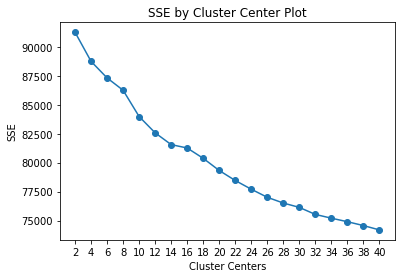

In [22]:
def find_optimal_clusters(data, max_k, batch_size):
    iters = range(2, max_k+1, 2)
    
    sse = []
    bar = tqdm(iters)
    for k in bar:
        sse.append(MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=20).fit(data).inertia_)
        bar.set_description('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

find_optimal_clusters(text, max_k, batch_size)

Compute cluster centers and predict cluster index for each sample.

In [26]:
clusters = MiniBatchKMeans(n_clusters=10, batch_size=batch_size, random_state=20).fit_predict(text)

text shape: (104034, 256)
clusters: (104034,) [6 3 2 ... 2 9 8]
Number of clusters: 10
Only calculate 5201 data points
Only draw 1040 data points


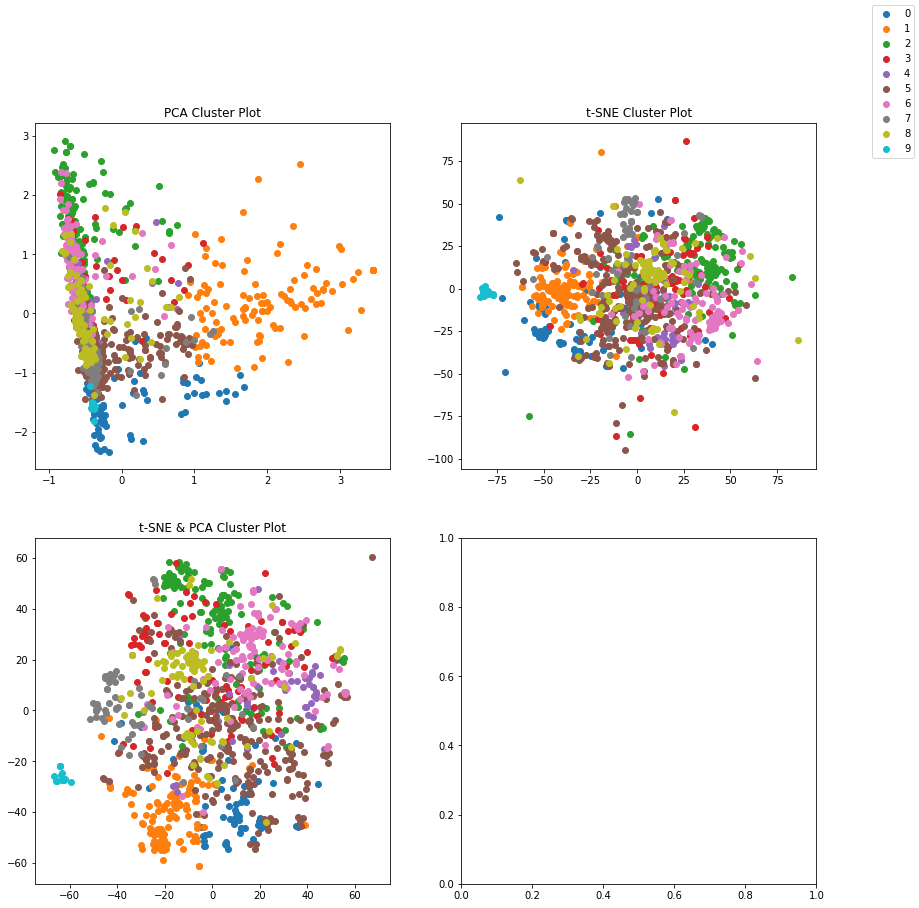

In [27]:
def plot_tsne_pca(data, labels):
    n_data = data.shape[0]
    
    # number of clusters
    max_label = max(labels) 
    print("Number of clusters: {}".format(max_label + 1))
    
    # random sample (n_sample) points
    np.random.seed(5)
    n_sample = n_data // 20
    print("Only calculate {} data points".format(n_sample))
    sample_items = np.random.choice(range(n_data), size=n_sample, replace=False)
    npdata = data[sample_items,:].todense()
    
    pca = PCA(n_components=2, whiten=True).fit_transform(npdata)
    tsne_pca = TSNE().fit_transform(PCA(n_components=(max_features // 2)).fit_transform(npdata))
    tsne = TSNE().fit_transform(npdata)
    
    # draw only (n_draw) points
    np.random.seed(5)
    n_draw = n_sample // 5
    print("Only draw {} data points".format(n_draw))
    idx = np.random.choice(range(pca.shape[0]), size=n_draw, replace=False)
    
    label_subset = labels[sample_items]
    
    # draw scatter
    f, ax = plt.subplots(2, 2, figsize=(14, 14))
    for i in range(max_label + 1):
        sub_idx = idx[label_subset[idx] == i]
        label_subset_color = np.array([cm.hsv(i/ ( max_label + 1)) for i in label_subset[sub_idx]])
        ax[0,0].scatter(pca[sub_idx, 0], pca[sub_idx, 1])   # , c=label_subset_color
        ax[0,0].set_title('PCA Cluster Plot')

        ax[1,0].set_title('t-SNE & PCA Cluster Plot')
        ax[1,0].scatter(tsne_pca[sub_idx, 0], tsne_pca[sub_idx, 1], label=str(i)) # , c=label_subset_color
        
        ax[0,1].set_title('t-SNE Cluster Plot')
        ax[0,1].scatter(tsne[sub_idx, 0], tsne[sub_idx, 1]) # , c=label_subset_color
        
    f.legend() # plot only one legend

print("text shape:", text.shape)
print("clusters:", clusters.shape, clusters)
plot_tsne_pca(text, clusters)

## Get keywords of each clusters

In [28]:
def get_top_keywords(data, text, clusters, labels, n_terms):
    text_feature = text.toarray()
    data = np.array(data)
    labels = np.array(labels)
    group = pd.DataFrame(text.todense()).groupby(clusters)
    #print("Data point in each group:\n", group.size())
    df = group.mean() # [(clusters) rows x (feature) columns]

    for i,r in df.iterrows():
        #print(text_feature[clusters == i,:])
        sub_text = data[clusters == i]
        sub_text_list = sub_text.tolist()
        sub_text_feature = text_feature[clusters == i]
        #print("sub_text: {} | sub_text_feature: {}".format(sub_text.shape,sub_text_feature.shape))
        dist = np.linalg.norm(sub_text_feature - np.array(r), axis=1)

        #print("Euclidean distance:", dist.shape, dist)
        
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        #print(','.join([str(r[t]) for t in np.argsort(r)[-n_terms:]]))
        print("")
        print('\n\n'.join([re.sub(' +', ' ',_filter(sub_text_list[t])) + " | " + str(dist[t]) for t in np.argsort(dist)[-2:]]))
            
get_top_keywords(reduced_data, text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
clip,play,make,try,audio,produce,file,use,edit,video

when I hit the PRODUCE button kicks me out of Power Director | 1.0272319686322555

When I hit the produce button it  | 1.0272319686322555

Cluster 1
try,screen,help,good,photo,error,video,app,file,attach

Why I can t overlay more tracks I thought up to track when I subscribe But why can t I only track Attach File Attach File  | 1.005259761599659

RE QuestionID Further to my reply today please also see the DxDiag bit report Attach File  | 1.0059653610134889

Cluster 2
purchase,ultra,product,software,send,need,number,order,link,download

IPlease I cannot fill the SR number Willem | 1.0199282589691578

MY INVOICE NUMBER IS OR CONFIRMATION IS  | 1.0201161897278315

Cluster 3
thank,number,address,use,need,software,product,download,email,purchase

how to type email | 1.0084370766909048

Hi I just purchased the ultra and it has other downloads listed that there my downloads will these downloads cost extra | 1.0130120430059244

C

## Test

In [ ]:
def top_tfidf_feats(row, features, top_n=50):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_feats_in_doc(Xtr, features, row_id, top_n=50):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

top_feats_in_doc(text,tfidf.get_feature_names(),2)

## Doc2vec

In [34]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [35]:
tagged_data = [TaggedDocument(words=nltk.word_tokenize(sentence), tags=[str(i)]) for i, sentence in enumerate(clean_data)]

In [37]:
max_epochs = 100
alpha = 0.025

model = Doc2Vec(vector_size=max_features,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0


KeyboardInterrupt: 

In [ ]:
model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])
